In [1]:
from eicvibe.machine_portal.lattice import Lattice
from eicvibe.machine_portal.bend import Bend
from eicvibe.machine_portal.drift import Drift
from eicvibe.machine_portal.quadrupole import Quadrupole
from eicvibe.machine_portal.monitor import Monitor
import numpy as np

In [2]:
d1= Drift(name="Drift1", length=1.0)
b1= Bend(name="Bend1", length=2.0)
b2= Bend(name="Bend2", length=2.0)
qf= Quadrupole(name="Quad1", length=0.6)
qd= Quadrupole(name="Quad2", length=0.6)
bpm1 = Monitor(name="BPM1")
bpm2 = Monitor(name="BPM2")
bpm3 = Monitor(name="BPM3")
bpm4 = Monitor(name="BPM4")




b1.add_parameter("BendP", "angle", np.pi/10)
b2.add_parameter("BendP", "angle", np.pi/10)

k=1.0/2.0
qf.add_parameter("MagneticMultipoleP", "kn1", -k)
qd.add_parameter("MagneticMultipoleP", "kn1", k)


qf.add_parameter("ApertureP", "X", [-0.05,0.05])

In [3]:
cell = [qf, d1, bpm1, b2, bpm2, d1, qd, d1, bpm3, b1, bpm4, d1]
fodo = Lattice(name="FODO")
for elem in cell:
    if elem.name not in fodo.elements:
        fodo.add_element(elem)

In [4]:
fodo = Lattice(name="FODO")
fodo.add_branch("FODO", cell)

In [5]:
fodo.get_element("Quad1_1")

Quadrupole(name=Quad1_1, type=Quadrupole, length=0.6, inherit=Quad1, parameters=[ParameterGroup(name=MagneticMultipoleP, type=MagneticMultipoleP, parameters={'kn1': -0.5}, subgroups=[]), ParameterGroup(name=ApertureP, type=ApertureP, parameters={'X': [-0.05, 0.05]}, subgroups=[])])

9.2

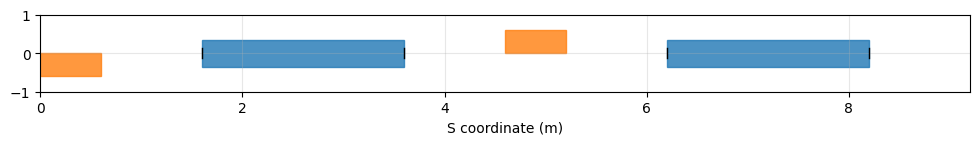

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 1))
fodo.plot_branch_beamline("FODO", ax=ax, start_s=0.0, normalized_strength=None)

((np.float64(8.623721071896902), np.float64(2.6070650133383126)),
 (np.float64(0.8090169943749473), np.float64(0.587785252292473)))

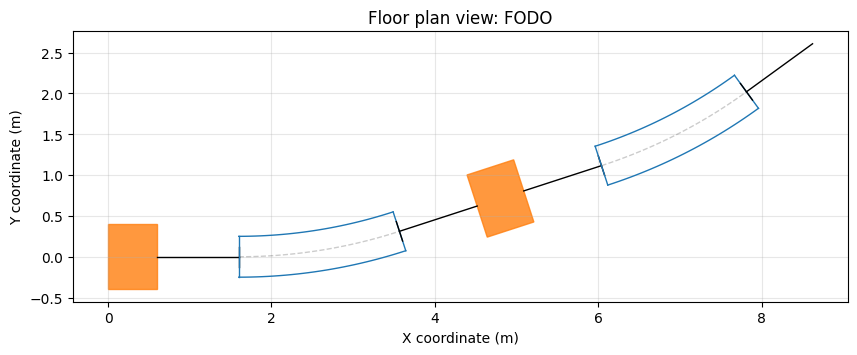

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
fodo.plot_branch_floorplan("FODO", ax=ax, )

## XSuite Simulation

Now let's simulate this FODO lattice using XSuite:

In [ ]:
# Import XSuite simulation interface
# Reload the module to get latest changes
import importlib
import eicvibe.simulators.xsuite_interface
importlib.reload(eicvibe.simulators.xsuite_interface)

from eicvibe.simulators.xsuite_interface import XSuiteSimulationEngine, XSUITE_AVAILABLE
from eicvibe.simulators.types import ParticleDistribution, DistributionType, SimulationMode

if not XSUITE_AVAILABLE:
    print("⚠️ XSuite not available - install with: uv add xsuite")
else:
    print("✓ XSuite is available")

✓ XSuite is available


In [ ]:
# Initialize XSuite simulation engine
engine = XSuiteSimulationEngine()
engine.initialize_engine()

# Convert EICViBE lattice to XSuite Line
# Pass BPM configuration during conversion (before build_tracker() is called)
num_turns = 1000
frev = 1e6  # 1 MHz revolution frequency

xsuite_line = engine.convert_lattice(
    fodo, 
    mode=SimulationMode.RING,
    bpm_num_turns=num_turns,
    bpm_frev=frev
)
print(f"✓ Converted lattice with {len(xsuite_line.element_names)} elements")

The line already has an associated tracker


Slicing line:   0%|          | 0/12 [00:00<?, ?it/s]

✓ Converted lattice with 828 elements


In [ ]:
# Compute Twiss parameters (optics functions)
# Set reference particle on the line object
import xpart as xp

# Create reference particle (e.g., 3 GeV electron)
xsuite_line.particle_ref = xp.Particles(p0c=3e9, mass0=xp.ELECTRON_MASS_EV)

# For a single FODO cell (not a closed ring), use 4D method
# This computes only transverse (x,y) optics without requiring longitudinal closure
twiss = xsuite_line.twiss(method='4d')

# Display key optics parameters
print(f"Beta functions at start:")
print(f"  βx = {twiss.betx[0]:.3f} m")
print(f"  βy = {twiss.bety[0]:.3f} m")
print(f"  alphax = {twiss.alfx[0]:.3f} m")
print(f"  alphay = {twiss.alfy[0]:.3f} m")
print(f"  dx = {twiss.dx[0]:.3f} m")
print(f"  dpx = {twiss.dpx[0]:.3f} m")
print(f"\nTune:")
print(f"  Qx = {twiss.qx:.4f}")
print(f"  Qy = {twiss.qy:.4f}")

Beta functions at start:
  βx = 2.511 m
  βy = 14.503 m
  alphax = 0.496 m
  alphay = -2.189 m
  dx = 1.547 m
  dpx = -0.229 m

Tune:
  Qx = 0.2833
  Qy = 0.2292


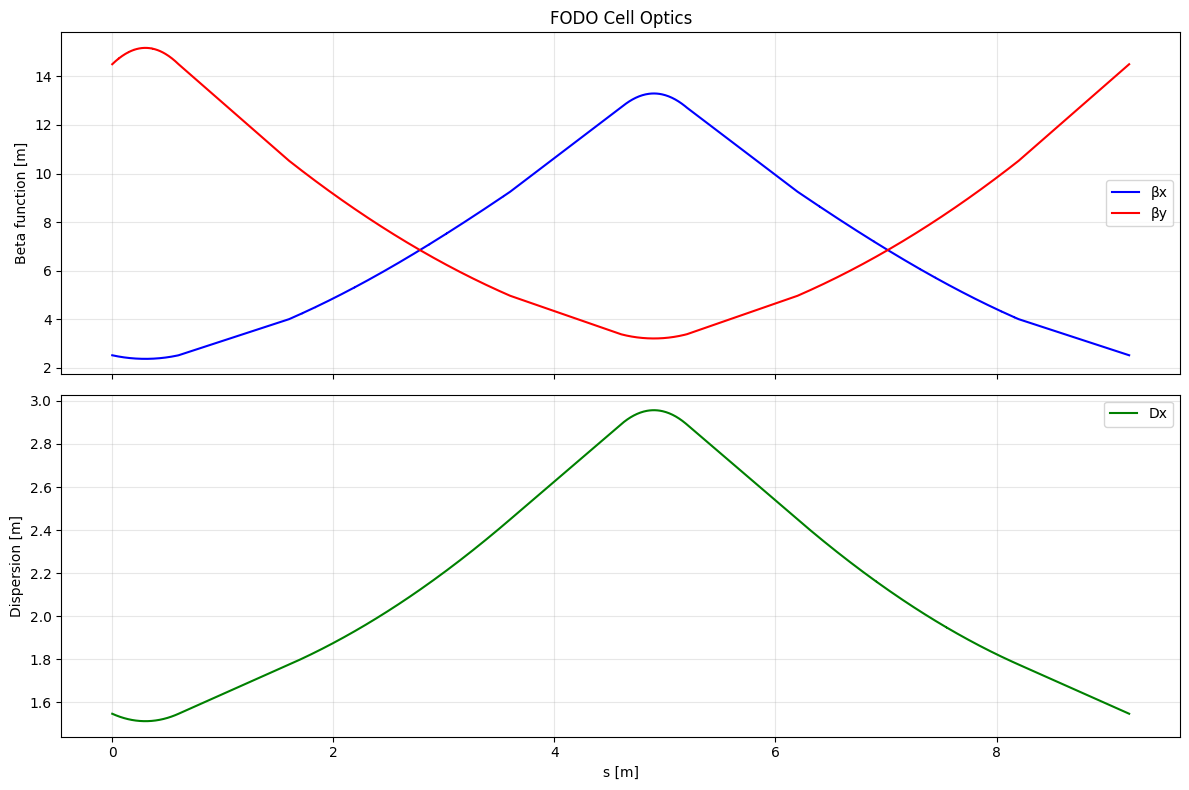

In [ ]:
# Plot beta functions
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Beta functions
ax1.plot(twiss.s, twiss.betx, 'b-', label='βx')
ax1.plot(twiss.s, twiss.bety, 'r-', label='βy')
ax1.set_ylabel('Beta function [m]')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('FODO Cell Optics')

# Dispersion
ax2.plot(twiss.s, twiss.dx, 'g-', label='Dx')
ax2.set_xlabel('s [m]')
ax2.set_ylabel('Dispersion [m]')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Create particle distribution
# Using a Gaussian distribution for beam simulation
particle_dist = ParticleDistribution(
    distribution_type=DistributionType.GAUSSIAN,
    num_particles=10000,
    energy=3e9,
    emittance_x=1e-9,    # m·rad
    emittance_y=1e-9,    # m·rad
    beta_x=twiss.betx[0],         # m
    beta_y=twiss.bety[0],         # m
    alpha_x=twiss.alfx[0],         
    alpha_y=twiss.alfy[0],
    dx=twiss.dx[0],
    dpx=twiss.dpx[0],
    x_mean = 0.00,    # 0 mm offset in x

    zeta_std=1e-2,   # 1 cm RMS bunch length
    delta_std=1e-3   # 0.1% momentum spread
)

particles = engine.create_particles(particle_dist)
print(f"✓ Created {len(particles.x)} particles")

✓ Created 10000 particles


In [ ]:
# The Monitor elements in the EICViBE lattice are automatically converted
# to xtrack.BeamPositionMonitor objects during lattice conversion
# BPMs are pre-configured with num_turns and frev during convert_lattice()

# Find BPM element names by checking element type (not by name string matching)
import xtrack as xt
bpm_names = [name for name, elem in zip(xsuite_line.element_names, xsuite_line.elements) 
             if isinstance(elem, xt.BeamPositionMonitor)]
print(f"Found {len(bpm_names)} BPMs in lattice: {bpm_names}")

# Get s-positions of BPMs
bpm_positions = {}
for bpm_name in bpm_names:
    bpm_positions[bpm_name] = xsuite_line.get_s_position(bpm_name)
    print(f"  {bpm_name} at s = {bpm_positions[bpm_name]:.3f} m")

# Create particles for tracking
particles = engine.create_particles(particle_dist)

# Track particles - BPMs automatically record centroid positions
xsuite_line.track(particles, num_turns=num_turns)

print(f"\n✓ Tracked {num_turns} turns")
print(f"Surviving particles: {np.sum(particles.state > 0)}/{len(particles.x)}")

# Get BPM data from the engine
bpm_data = engine.get_bpm_data()

print(f"\nBPM readouts (beam centroids):")
for bpm_name in bpm_names:
    if bpm_name in bpm_data:
        bpm = bpm_data[bpm_name]
        print(f"  {bpm_name}: {len(bpm.x_mean)} samples")
        print(f"    <x> = {np.mean(bpm.x_mean)*1e3:.3f} ± {np.std(bpm.x_mean)*1e3:.3f} mm")
        print(f"    <y> = {np.mean(bpm.y_mean)*1e3:.3f} ± {np.std(bpm.y_mean)*1e3:.3f} mm")


Found 4 BPMs in lattice: ['BPM1_1', 'BPM2_1', 'BPM3_1', 'BPM4_1']
  BPM1_1 at s = 1.600 m
  BPM2_1 at s = 3.600 m
  BPM3_1 at s = 6.200 m
  BPM4_1 at s = 8.200 m

✓ Tracked 1000 turns
Surviving particles: 10000/10000

BPM readouts (beam centroids):
  BPM1_1: 1000 samples
    <x> = 0.007 ± 0.001 mm
    <y> = -0.000 ± 0.001 mm
  BPM2_1: 1000 samples
    <x> = 0.009 ± 0.001 mm
    <y> = -0.000 ± 0.001 mm
  BPM3_1: 1000 samples
    <x> = 0.009 ± 0.001 mm
    <y> = 0.000 ± 0.001 mm
  BPM4_1: 1000 samples
    <x> = 0.007 ± 0.001 mm
    <y> = 0.000 ± 0.001 mm


## BPM (Beam Position Monitor) Tracking

The Monitor elements defined in the EICViBE lattice are **automatically converted** to `xtrack.BeamPositionMonitor` objects during lattice conversion. No manual insertion needed!

**What BPMs measure:**
- **Beam centroid positions** (x_mean, y_mean) at each turn
- **Beam intensity** (number of particles)

**What BPMs cannot measure:**
- Beam sizes (σ_x, σ_y) - these require wire scanners or other diagnostic devices
- Individual particle coordinates

This implementation reflects real accelerator physics: BPMs measure the electromagnetic center-of-charge of the beam, not the beam envelope or individual particles.


In [ ]:
# Extract turn-by-turn data from the automatically created BPM monitors
# BeamPositionMonitors record beam centroids (x_mean, y_mean) not individual particles

# Debug: Check what's in bpm_data
print(f"BPM data keys: {list(bpm_data.keys())}")
print(f"BPM names from lattice: {bpm_names}")

# Use first BPM for detailed analysis
if len(bpm_data) == 0:
    print("⚠️ No BPM data recorded!")
    print("Make sure configure_bpm_tracking() was called before tracking")
else:
    first_bpm = bpm_names[0]
    if first_bpm not in bpm_data:
        print(f"⚠️ {first_bpm} not in bpm_data, using first available BPM")
        first_bpm = list(bpm_data.keys())[0]
    
    monitor = bpm_data[first_bpm]
    
    print(f"\nAnalyzing data from {first_bpm} at s = {bpm_positions[first_bpm]:.3f} m")
    print(f"Monitor data shape:")
    print(f"  x_mean: {monitor.x_mean.shape} (beam centroid per turn)")
    print(f"  y_mean: {monitor.y_mean.shape}")
    
    # BeamPositionMonitor gives us centroids directly
    x_centroid = monitor.x_mean
    y_centroid = monitor.y_mean
    
    print(f"\nBeam centroid motion at {first_bpm}:")
    print(f"  x range: [{np.min(x_centroid)*1e3:.3f}, {np.max(x_centroid)*1e3:.3f}] mm")
    print(f"  y range: [{np.min(y_centroid)*1e3:.3f}, {np.max(y_centroid)*1e3:.3f}] mm")
    print(f"  x RMS oscillation: {np.std(x_centroid)*1e3:.3f} mm")
    print(f"  y RMS oscillation: {np.std(y_centroid)*1e3:.3f} mm")
    
    # Summary of all BPMs
    print(f"\n{'BPM':<12} {'s [m]':<10} {'<x> [mm]':<12} {'σ_x_osc [mm]':<15} {'<y> [mm]':<12} {'σ_y_osc [mm]':<15}")
    print("-" * 85)
    for bpm_name in bpm_names:
        if bpm_name in bpm_data:
            bpm = bpm_data[bpm_name]
            x_mean = np.mean(bpm.x_mean)
            x_std = np.std(bpm.x_mean)
            y_mean = np.mean(bpm.y_mean)
            y_std = np.std(bpm.y_mean)
            print(f"{bpm_name:<12} {bpm_positions[bpm_name]:<10.3f} {x_mean*1e3:<12.3f} {x_std*1e3:<15.3f} {y_mean*1e3:<12.3f} {y_std*1e3:<15.3f}")


BPM data keys: ['BPM1_1', 'BPM2_1', 'BPM3_1', 'BPM4_1']
BPM names from lattice: ['BPM1_1', 'BPM2_1', 'BPM3_1', 'BPM4_1']

Analyzing data from BPM1_1 at s = 1.600 m
Monitor data shape:
  x_mean: (1000,) (beam centroid per turn)
  y_mean: (1000,)

Beam centroid motion at BPM1_1:
  x range: [0.005, 0.010] mm
  y range: [-0.002, 0.002] mm
  x RMS oscillation: 0.001 mm
  y RMS oscillation: 0.001 mm

BPM          s [m]      <x> [mm]     σ_x_osc [mm]    <y> [mm]     σ_y_osc [mm]   
-------------------------------------------------------------------------------------
BPM1_1       1.600      0.007        0.001           -0.000       0.001          
BPM2_1       3.600      0.009        0.001           -0.000       0.001          
BPM3_1       6.200      0.009        0.001           0.000        0.001          
BPM4_1       8.200      0.007        0.001           0.000        0.001          


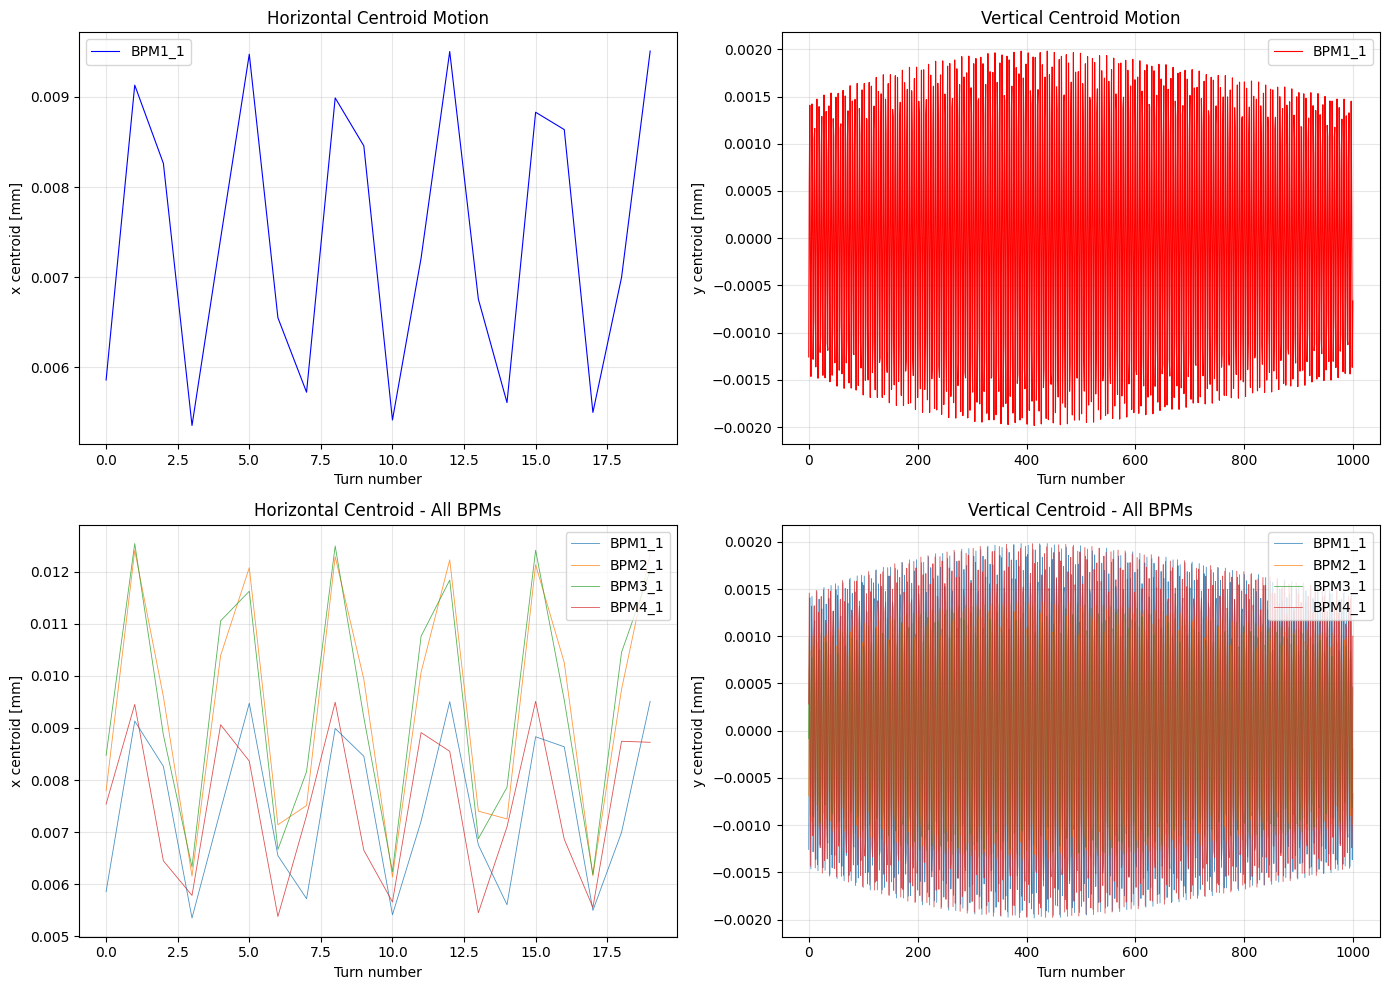

In [ ]:
# Plot turn-by-turn beam centroid motion from BPMs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

turns = np.arange(len(x_centroid))

# X centroid vs turn (first BPM)
axes[0, 0].plot(turns[0:20], x_centroid[0:20] * 1e3, 'b-', linewidth=0.8, label=first_bpm)
axes[0, 0].set_xlabel('Turn number')
axes[0, 0].set_ylabel('x centroid [mm]')
axes[0, 0].set_title('Horizontal Centroid Motion')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Y centroid vs turn (first BPM)
axes[0, 1].plot(turns, y_centroid * 1e3, 'r-', linewidth=0.8, label=first_bpm)
axes[0, 1].set_xlabel('Turn number')
axes[0, 1].set_ylabel('y centroid [mm]')
axes[0, 1].set_title('Vertical Centroid Motion')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Compare all BPMs - horizontal
for bpm_name in bpm_names:
    if bpm_name in bpm_data:
        bpm = bpm_data[bpm_name]
        axes[1, 0].plot(turns[0:20], bpm.x_mean[0:20] * 1e3, linewidth=0.6, label=bpm_name, alpha=0.8)
axes[1, 0].set_xlabel('Turn number')
axes[1, 0].set_ylabel('x centroid [mm]')
axes[1, 0].set_title('Horizontal Centroid - All BPMs')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Compare all BPMs - vertical
for bpm_name in bpm_names:
    if bpm_name in bpm_data:
        bpm = bpm_data[bpm_name]
        axes[1, 1].plot(turns, bpm.y_mean * 1e3, linewidth=0.6, label=bpm_name, alpha=0.8)
axes[1, 1].set_xlabel('Turn number')
axes[1, 1].set_ylabel('y centroid [mm]')
axes[1, 1].set_title('Vertical Centroid - All BPMs')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


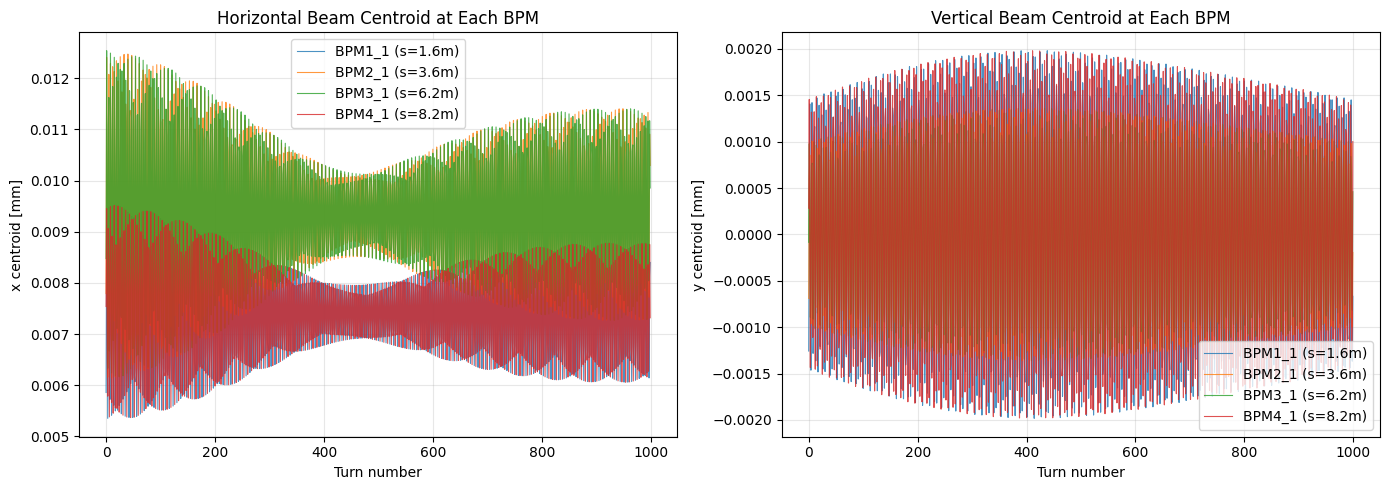

In [ ]:
# Compare BPM readings at different locations along the lattice
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Horizontal centroid evolution at different BPMs
for bpm_name in bpm_names:
    if bpm_name in bpm_data:
        bpm = bpm_data[bpm_name]
        s_pos = bpm_positions[bpm_name]
        ax1.plot(turns, bpm.x_mean * 1e3, linewidth=0.8, 
                 label=f'{bpm_name} (s={s_pos:.1f}m)', alpha=0.8)

ax1.set_xlabel('Turn number')
ax1.set_ylabel('x centroid [mm]')
ax1.set_title('Horizontal Beam Centroid at Each BPM')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Vertical centroid evolution at different BPMs
for bpm_name in bpm_names:
    if bpm_name in bpm_data:
        bpm = bpm_data[bpm_name]
        s_pos = bpm_positions[bpm_name]
        ax2.plot(turns, bpm.y_mean * 1e3, linewidth=0.8, 
                 label=f'{bpm_name} (s={s_pos:.1f}m)', alpha=0.8)

ax2.set_xlabel('Turn number')
ax2.set_ylabel('y centroid [mm]')
ax2.set_title('Vertical Beam Centroid at Each BPM')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Measured horizontal tune from BPM centroid: Qx ≈ 0.2840
Expected from Twiss: Qx = 0.2833
Difference: 0.0007


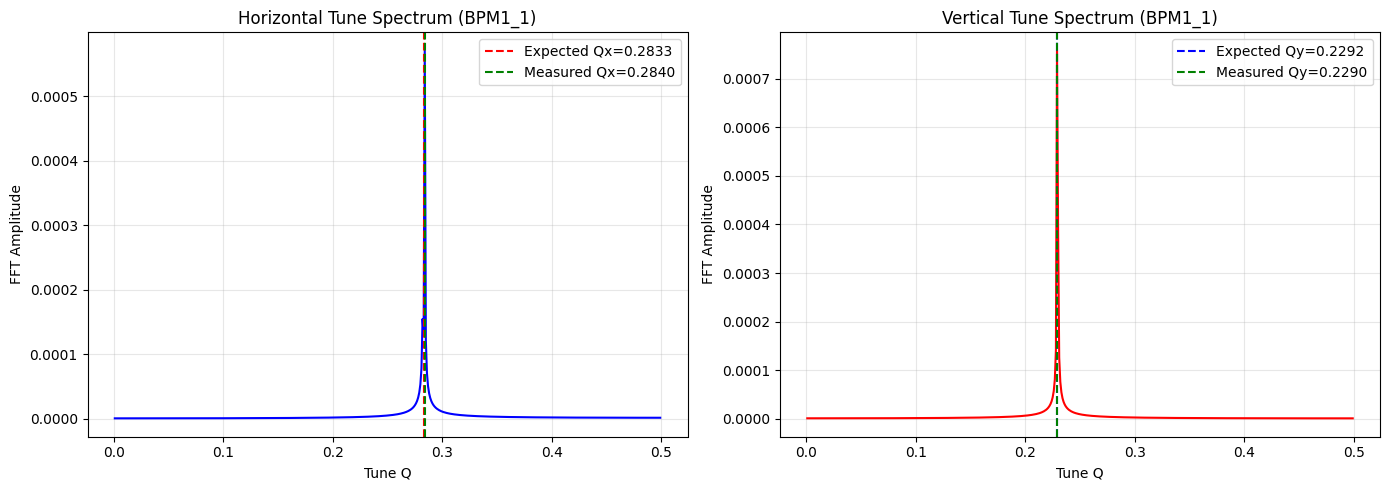


Measured vertical tune from BPM centroid: Qy ≈ 0.2290
Expected from Twiss: Qy = 0.2292
Difference: 0.0002


In [ ]:
# Compute betatron tune from BPM centroid oscillations
# Use FFT to find dominant oscillation frequency
from scipy.fft import fft, fftfreq

# Analyze horizontal centroid motion from first BPM
x_signal = monitor.x_mean
x_fft = fft(x_signal)
freqs = fftfreq(len(x_signal))

# Find dominant frequency (positive frequencies only)
positive_freqs = freqs[:len(freqs)//2]
positive_fft = np.abs(x_fft[:len(x_fft)//2])

# Get tune (fractional part of dominant frequency)
dominant_idx = np.argmax(positive_fft[1:]) + 1  # Skip DC component
tune_x_measured = positive_freqs[dominant_idx]

print(f"Measured horizontal tune from BPM centroid: Qx ≈ {tune_x_measured:.4f}")
print(f"Expected from Twiss: Qx = {twiss.qx:.4f}")
print(f"Difference: {abs(tune_x_measured - twiss.qx):.4f}")

# Plot FFT spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Horizontal tune spectrum
ax1.plot(positive_freqs[1:5000], positive_fft[1:5000], 'b-')
ax1.axvline(twiss.qx, color='r', linestyle='--', label=f'Expected Qx={twiss.qx:.4f}')
ax1.axvline(tune_x_measured, color='g', linestyle='--', label=f'Measured Qx={tune_x_measured:.4f}')
ax1.set_xlabel('Tune Q')
ax1.set_ylabel('FFT Amplitude')
ax1.set_title(f'Horizontal Tune Spectrum ({first_bpm})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Vertical tune analysis
y_signal = monitor.y_mean
y_fft = fft(y_signal)
positive_fft_y = np.abs(y_fft[:len(y_fft)//2])
dominant_idx_y = np.argmax(positive_fft_y[1:]) + 1
tune_y_measured = positive_freqs[dominant_idx_y]

ax2.plot(positive_freqs[1:5000], positive_fft_y[1:5000], 'r-')
ax2.axvline(twiss.qy, color='b', linestyle='--', label=f'Expected Qy={twiss.qy:.4f}')
ax2.axvline(tune_y_measured, color='g', linestyle='--', label=f'Measured Qy={tune_y_measured:.4f}')
ax2.set_xlabel('Tune Q')
ax2.set_ylabel('FFT Amplitude')
ax2.set_title(f'Vertical Tune Spectrum ({first_bpm})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMeasured vertical tune from BPM centroid: Qy ≈ {tune_y_measured:.4f}")
print(f"Expected from Twiss: Qy = {twiss.qy:.4f}")
print(f"Difference: {abs(tune_y_measured - twiss.qy):.4f}")


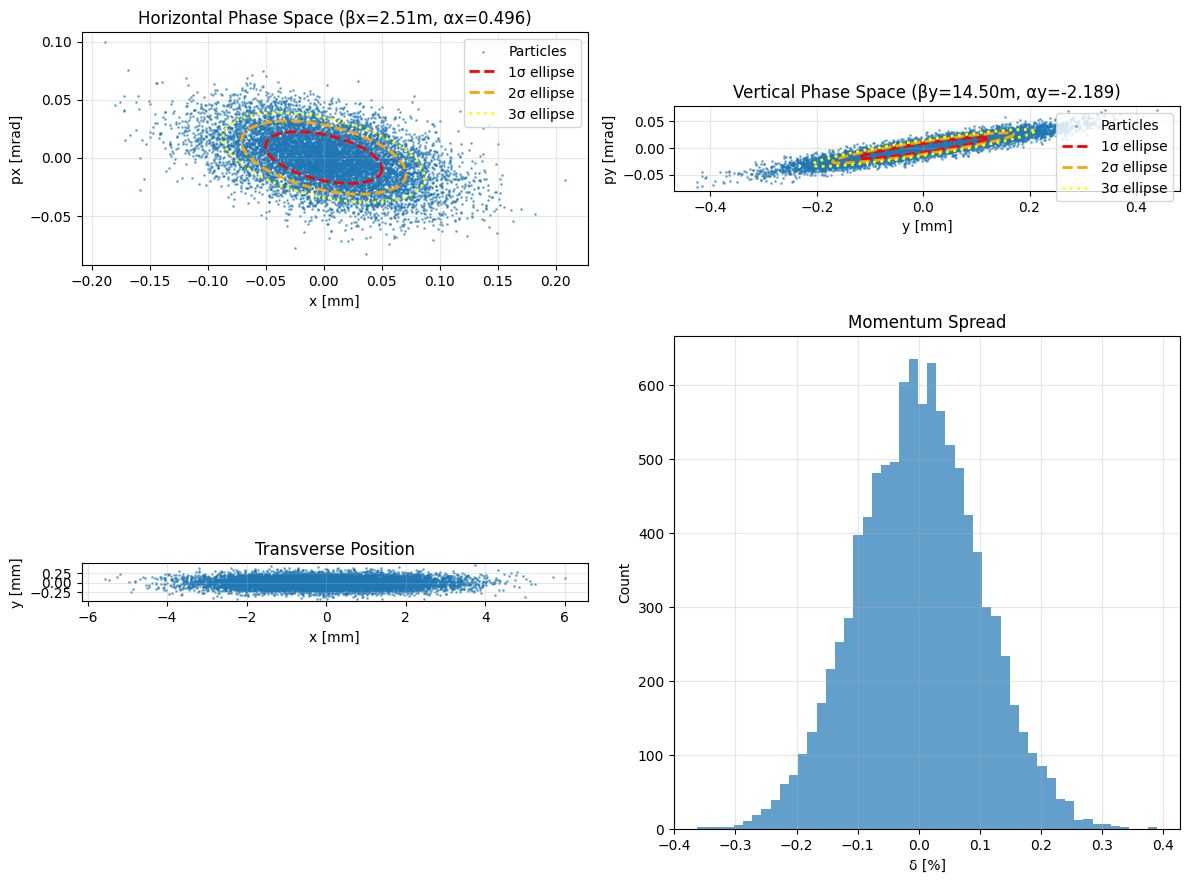

In [ ]:
# Visualize particle distribution in phase space
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Get Twiss parameters at start
beta_x = twiss.betx[0]
alpha_x = twiss.alfx[0]
gamma_x = (1 + alpha_x**2) / beta_x

beta_y = twiss.bety[0]
alpha_y = twiss.alfy[0]
gamma_y = (1 + alpha_y**2) / beta_y

# Calculate actual emittance from particles
emit_x = particle_dist.emittance_x
emit_y = particle_dist.emittance_y

# Create phase space ellipse based on Twiss parameters
# Ellipse equation: γx² + 2αx·px + βpx² = ε
def phase_space_ellipse(beta, alpha, emittance, n_sigma=2, n_points=100):
    """Generate phase space ellipse for given Twiss parameters"""
    gamma = (1 + alpha**2) / beta
    # Parametric form: angle from 0 to 2π
    theta = np.linspace(0, 2*np.pi, n_points)
    # In normalized coordinates
    x_ellipse = np.sqrt(n_sigma * emittance * beta) * np.cos(theta)
    px_ellipse = -np.sqrt(n_sigma * emittance / beta) * (alpha * np.cos(theta) + np.sin(theta))
    return x_ellipse, px_ellipse

# x-px phase space
# Remove dispersion to show betatron motion only
x_betatron = (particles.x - twiss.dx[0] * particles.delta) * 1e3
px_betatron = (particles.px - twiss.dpx[0] * particles.delta) * 1e3
axes[0, 0].scatter(x_betatron, px_betatron, s=1, alpha=0.5, label='Particles')

# Plot theoretical ellipses (1σ, 2σ, 3σ)
for n_sig, color, ls in [(1, 'red', '--'), (2, 'orange', '--'), (3, 'yellow', ':')]:
    x_ell, px_ell = phase_space_ellipse(beta_x, alpha_x, emit_x, n_sigma=n_sig)
    axes[0, 0].plot(x_ell * 1e3, px_ell * 1e3, color=color, linestyle=ls, 
                    linewidth=2, label=f'{n_sig}σ ellipse')

axes[0, 0].set_xlabel('x [mm]')
axes[0, 0].set_ylabel('px [mrad]')
axes[0, 0].set_title(f'Horizontal Phase Space (βx={beta_x:.2f}m, αx={alpha_x:.3f})')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_aspect('equal')

# y-py phase space
y_betatron = particles.y * 1e3
py_betatron = particles.py * 1e3
axes[0, 1].scatter(y_betatron, py_betatron, s=1, alpha=0.5, label='Particles')

# Plot theoretical ellipses
for n_sig, color, ls in [(1, 'red', '--'), (2, 'orange', '--'), (3, 'yellow', ':')]:
    y_ell, py_ell = phase_space_ellipse(beta_y, alpha_y, emit_y, n_sigma=n_sig)
    axes[0, 1].plot(y_ell * 1e3, py_ell * 1e3, color=color, linestyle=ls, 
                    linewidth=2, label=f'{n_sig}σ ellipse')

axes[0, 1].set_xlabel('y [mm]')
axes[0, 1].set_ylabel('py [mrad]')
axes[0, 1].set_title(f'Vertical Phase Space (βy={beta_y:.2f}m, αy={alpha_y:.3f})')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_aspect('equal')

# x-y real space
axes[1, 0].scatter(particles.x * 1e3, particles.y * 1e3, s=1, alpha=0.5)
axes[1, 0].set_xlabel('x [mm]')
axes[1, 0].set_ylabel('y [mm]')
axes[1, 0].set_title('Transverse Position')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_aspect('equal')

# Energy distribution
axes[1, 1].hist(particles.delta * 100, bins=50, alpha=0.7)
axes[1, 1].set_xlabel('δ [%]')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Momentum Spread')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

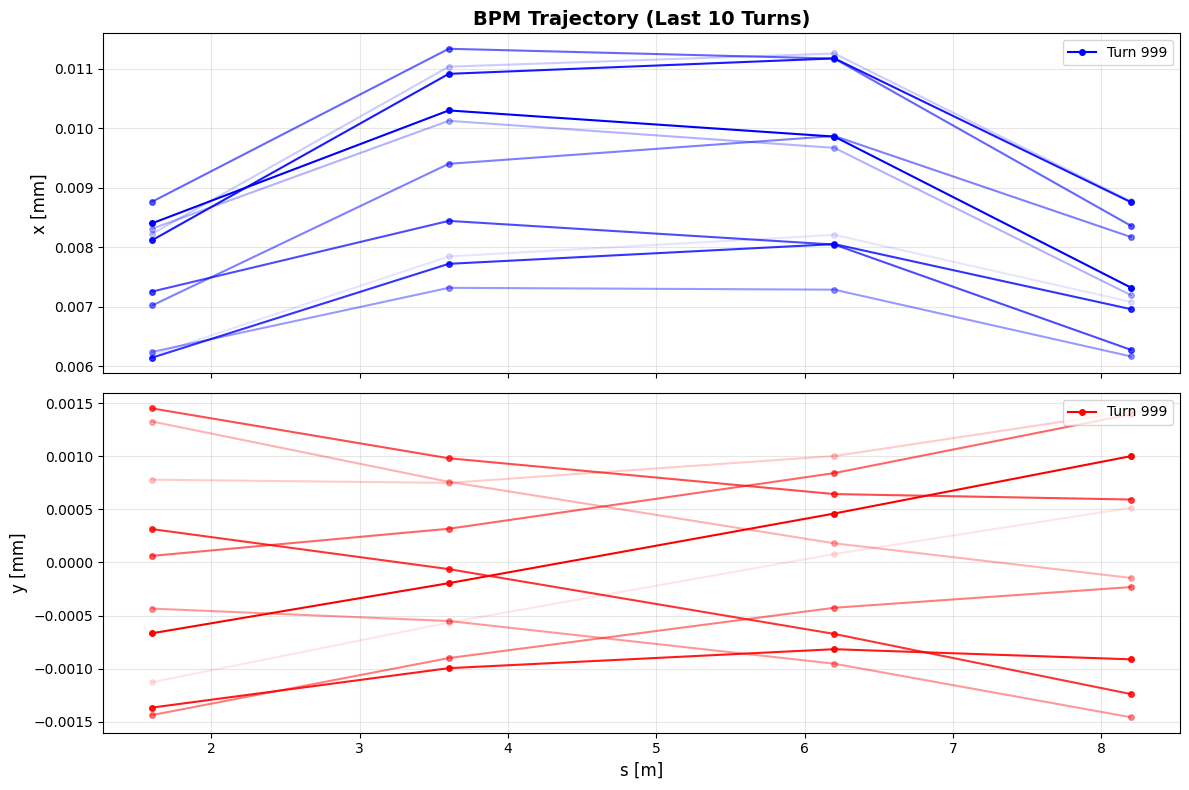

✓ Plotted BPM trajectories for last 10 turns
  Oldest turn (faded): Turn 990
  Newest turn (solid): Turn 999


In [ ]:
# Plot BPM trajectories as function of s for the last 10 turns with fading effect
import matplotlib.pyplot as plt
import numpy as np

# Number of turns to display
n_display_turns = 10

# Get the last n_display_turns from BPM data
last_turns = min(n_display_turns, num_turns)

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Collect all BPM s-positions and data
s_positions = []
x_data_by_turn = [[] for _ in range(last_turns)]
y_data_by_turn = [[] for _ in range(last_turns)]

for bpm_name in sorted(bpm_names, key=lambda n: bpm_positions[n]):
    if bpm_name in bpm_data:
        bpm = bpm_data[bpm_name]
        s_pos = bpm_positions[bpm_name]
        s_positions.append(s_pos)
        
        # Extract last n_display_turns
        for i in range(last_turns):
            turn_idx = num_turns - last_turns + i
            x_data_by_turn[i].append(bpm.x_mean[turn_idx] * 1e3)  # Convert to mm
            y_data_by_turn[i].append(bpm.y_mean[turn_idx] * 1e3)

# Plot with fading effect (oldest turn has lowest alpha, newest has highest)
for i in range(last_turns):
    turn_number = num_turns - last_turns + i
    alpha = (i + 1) / last_turns  # Fading: 0.1 to 1.0
    
    ax1.plot(s_positions, x_data_by_turn[i], 'o-', 
             alpha=alpha, color='blue', linewidth=1.5, markersize=4,
             label=f'Turn {turn_number}' if i == last_turns - 1 else '')
    ax2.plot(s_positions, y_data_by_turn[i], 'o-', 
             alpha=alpha, color='red', linewidth=1.5, markersize=4,
             label=f'Turn {turn_number}' if i == last_turns - 1 else '')

# Formatting
ax1.set_ylabel('x [mm]', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_title(f'BPM Trajectory (Last {last_turns} Turns)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)

ax2.set_ylabel('y [mm]', fontsize=12)
ax2.set_xlabel('s [m]', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"✓ Plotted BPM trajectories for last {last_turns} turns")
print(f"  Oldest turn (faded): Turn {num_turns - last_turns}")
print(f"  Newest turn (solid): Turn {num_turns - 1}")

## Interactive Parameter Modification During Tracking

This section demonstrates modifying lattice parameters during tracking in ring mode.
The beam responds dynamically to parameter changes, which is observable through BPM readings.

In [ ]:
# Setup for interactive parameter changes
# We'll modify the quadrupole strength and observe the beam response

# IMPORTANT: Create a fresh lattice conversion with new BPM configuration
# BPMs have internal state and need to be reconfigured for multi-segment tracking

# Configure BPMs for the total number of turns we'll track
segment_turns = 100
total_segments = 10
total_interactive_turns = segment_turns * total_segments

print(f"Converting fresh lattice for interactive tracking...")
print(f"Configuration: {segment_turns} turns/segment × {total_segments} segments = {total_interactive_turns} total turns")

# Convert lattice with BPMs configured for total turns
xsuite_line_interactive = engine.convert_lattice(
    fodo, 
    mode=SimulationMode.RING,
    bpm_num_turns=total_interactive_turns,
    bpm_frev=frev
)
print(f"✓ Converted lattice with {len(xsuite_line_interactive.element_names)} elements")

# Re-initialize with fresh particles
particles_interactive = engine.create_particles(particle_dist)

# Find quadrupole elements by name pattern
# After slicing, original "Quad1" becomes "Quad1..0", "Quad1..1", etc.
# We can access the thick element parameters using the original name
import xtrack as xt

# Get all element names and look for quadrupole patterns
all_names = xsuite_line_interactive.element_names

print(f"Element names in lattice (first 30): {all_names[:30]}")

# After slicing, look for actual quadrupole slice elements (with '..' in name)
# Find all unique base names (before '..')
base_names = set()
for name in all_names:
    if '..' in name:
        base_name = name.split('..')[0]
        # Skip drift slices, only take quad slices
        if 'Quad' in base_name and 'drift' not in base_name:
            base_names.add(base_name)

quad_names = sorted(list(base_names))
print(f"Found {len(quad_names)} quadrupole base names: {quad_names}")

if len(quad_names) == 0:
    raise ValueError("No quadrupole elements found! Check lattice conversion.")

# Choose first focusing quadrupole
target_quad = quad_names[0]

# Access the compound element (thick element) to modify its parameters
# For sliced lattices, we access the compound element reference
try:
    # Get the compound element (the parent thick element)
    # XSuite stores this in the element_dict with the base name
    compound_elem = xsuite_line_interactive.element_dict[target_quad]
    
    # Check if it has k1 attribute
    if hasattr(compound_elem, 'k1'):
        original_k1 = compound_elem.k1
        print(f"\n✓ Successfully accessed {target_quad}")
        print(f"Original k1 = {original_k1:.4f} m^-2")
        print(f"Element type: {type(compound_elem).__name__}")
    else:
        # Try accessing the first slice element which should have k1
        first_slice = f"{target_quad}..0"
        if first_slice in xsuite_line_interactive.element_names:
            slice_elem = xsuite_line_interactive.element_dict[first_slice]
            original_k1 = slice_elem.k1
            print(f"\n✓ Accessed via slice: {first_slice}")
            print(f"Original k1 = {original_k1:.4f} m^-2")
            print(f"Element type: {type(slice_elem).__name__}")
        else:
            raise AttributeError(f"Could not find k1 parameter for {target_quad}")
            
except Exception as e:
    print(f"Error accessing k1: {e}")
    print(f"Trying different approach...")
    # List some element names to debug
    for i, name in enumerate(all_names[:50]):
        elem = xsuite_line_interactive.element_dict[name]
        if hasattr(elem, 'k1'):
            print(f"  {name}: type={type(elem).__name__}, k1={elem.k1:.4f}")
            if i > 5:
                break
    raise

print(f"\n✓ Setup complete for interactive tracking")


Converting fresh lattice for interactive tracking...
Configuration: 100 turns/segment × 10 segments = 1000 total turns
The line already has an associated tracker


Slicing line:   0%|          | 0/12 [00:00<?, ?it/s]

✓ Converted lattice with 828 elements
Element names in lattice (first 30): ['Quad1_1_entry', 'Quad1_1..entry_map', 'drift_Quad1_1..0', 'Quad1_1..0', 'drift_Quad1_1..1', 'Quad1_1..1', 'drift_Quad1_1..2', 'Quad1_1..2', 'drift_Quad1_1..3', 'Quad1_1..3', 'drift_Quad1_1..4', 'Quad1_1..4', 'drift_Quad1_1..5', 'Quad1_1..5', 'drift_Quad1_1..6', 'Quad1_1..6', 'drift_Quad1_1..7', 'Quad1_1..7', 'drift_Quad1_1..8', 'Quad1_1..8', 'drift_Quad1_1..9', 'Quad1_1..9', 'drift_Quad1_1..10', 'Quad1_1..10', 'drift_Quad1_1..11', 'Quad1_1..11', 'drift_Quad1_1..12', 'Quad1_1..12', 'drift_Quad1_1..13', 'Quad1_1..13']
Found 2 quadrupole base names: ['Quad1_1', 'Quad2_1']

✓ Successfully accessed Quad1_1
Original k1 = -0.5000 m^-2
Element type: Quadrupole

✓ Setup complete for interactive tracking


### Real-Time Interactive Control

For true real-time control, we can use IPython widgets to create an interactive interface: